same as `NAHEA_CNN_sin.ipynb`, but different random seed

In [1]:
import copy
import os
import sys
from pathlib import Path

import numpy as np
from qutip.solver.floquet import progress_bars
import torch
from pulser import Pulse, Register, Sequence
from pulser.devices import MockDevice
from pulser_diff.backend import TorchEmulator
from pyqtorch.utils import SolverType
from torch import Tensor
import json
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import h5py as h5
import scienceplots

In [ ]:
seed = 42
np.random.seed(42)
torch.manual_seed(42)

In [3]:
sys.path.append("../../..")

In [4]:
from source.NAHEA_CNN import NAHEA_CNN_1

In [5]:
plt.style.use(["science", "grid"])

In [6]:
# load data from sin dataset
data_save_dir = Path("../../../data") / "sin"
data_save_path_train = data_save_dir / "train.h5"
data_save_path_test = data_save_dir / "test.h5"

with h5.File(data_save_path_train, "r") as f:
    X_train_full = f["X"][:].squeeze(2)
    y_train_full = f["y"][:]

with h5.File(data_save_path_test, "r") as f:
    X_test = f["X"][:].squeeze(2)
    y_test = f["y"][:]

print(f"X_train shape: {X_train_full.shape}")
print(f"y_train shape: {y_train_full.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (4000, 18)
y_train shape: (4000, 1)
X_test shape: (1000, 18)
y_test shape: (1000, 1)


In [7]:
n_train = 150
n_val = 250 # validation is much faster than training
n_test = 500 # testing is much faster than training
X_train = X_train_full[:n_train]
y_train = y_train_full[:n_train]
X_val = X_train_full[n_train:n_train+n_val]
y_val = y_train_full[n_train:n_train+n_val]
X_test = X_test[:n_test]
y_test = y_test[:n_test]

seq_len = X_train.shape[1]

In [8]:
y_train.max()

0.9954053168508935

In [9]:
y_train.min()

0.11074481863268679

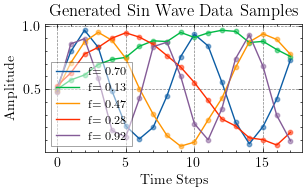

In [10]:
# plot some data
textwidth = 3.31314
aspect_ratio = 4/8
scale = 1.0
width = textwidth * scale
height = width * aspect_ratio
fig = plt.figure(figsize=(width, height))
# plt.figure(figsize=(10, 5))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i in range(5):
    plt.plot(X_train[i].flatten(), label=f"f= {y_train[i][0]:.2f}", color=colors[i % len(colors)])
    plt.scatter(np.arange(seq_len), X_train[i].flatten(), color=colors[i % len(colors)], s=10, alpha=0.5)
plt.title("Generated Sin Wave Data Samples")
plt.xlabel("Time Steps")
plt.ylabel("Amplitude")
legend = plt.legend(fancybox=False, edgecolor="black", fontsize='small', framealpha=0.5)
legend.get_frame().set_linewidth(0.5)
path = Path("figures")
path.mkdir(parents=True, exist_ok=True)
# plt.savefig(path / "generated_sin_wave_data_samples.pdf", bbox_inches='tight', dpi=300)
# print(f"Saved figure to {path / 'generated_sin_wave_data_samples.pdf'}")
plt.show()

In [11]:
seq_len = X_train.shape[1]
hparams = {
    "n_features": (n_features := 4),  # =1D kernel size = number of qubits
    "sampling_rate": 0.2,
    "protocol": "min-delay",
    "n_ancilliary_qubits": (n_ancilliary_qubits := 0), # not implemented
    "input_length": seq_len,
    "stride": 3,  # stride for the convolution
    "output_dim": 1,  # output dimension of the final FC NN
    "hidden_layers_dims": [10, 5],
}

sep = 7.0
parameters = {
    # separation of 7 between the qubits
    "positions": [[sep * i - (sep * 2), 0] for i in range(n_features)],
    "local_pulses_omega_1": [0.5, 1.0, 1.5, 1.0], #, 0.5],
    "local_pulses_delta_1": [0.0] * n_features,
    "global_pulse_omega_1": 1.0,
    "global_pulse_delta_1": 0.0,
    "global_pulse_omega_2": 0.5,
    "global_pulse_delta_2": 0.0,
    "global_pulse_duration": 100,
    "local_pulse_duration": 80,
    "embed_pulse_duration": 80,
}


NAHEA_CNN = NAHEA_CNN_1(
    hparams=hparams, parameters=parameters, name="NAHEA_CNN_3"
)

# set some parameters to not require gradients. They didn't change much last time
NAHEA_CNN._parameters["positions"].requires_grad = False
NAHEA_CNN._parameters["local_pulses_delta_1"].requires_grad = False
NAHEA_CNN._parameters["global_pulse_delta_1"].requires_grad = False
NAHEA_CNN._parameters["global_pulse_delta_2"].requires_grad = False

Adding parameter 0.weight to model
Adding parameter 0.bias to model
Adding parameter 2.weight to model
Adding parameter 2.bias to model
Adding parameter 4.weight to model
Adding parameter 4.bias to model


In [13]:
from multiprocessing import Pool

def forward_no_grad(xx: Tensor):
    with torch.no_grad():
        return NAHEA_CNN.forward(xx, dist_grad=False)
n_cpus = 4

In [14]:
# train the model
x_val = torch.tensor(X_val, dtype=torch.float64)
y_val = torch.tensor(y_val, dtype=torch.float64)
if len(y_val.shape) == 2:
    y_val = y_val.squeeze(1)  # make sure y_val is 2D
batch_size = 16
epochs = 50
loss_hist = []
loss_hist_val = []
# MSE loss function
loss_fn = torch.nn.MSELoss()
NAHEA_CNN.train()
optimizer = torch.optim.Adam(
    [param for _, param in NAHEA_CNN.parameters().items() if param.requires_grad],
    lr=0.01,
    weight_decay=1e-5,
)
params_hist = [copy.deepcopy(NAHEA_CNN.parameters())]
for epoch in range(epochs):
    NAHEA_CNN.train()
    # shuffle X_train and y_train
    idxs = np.arange(len(X_train))
    idxs = np.random.permutation(idxs)
    X_train = X_train[idxs]
    y_train = y_train[idxs]

    epoch_losses = []
    for i in tqdm(range(0, len(X_train), batch_size), desc=f"Epoch {epoch+1}", leave=False):
        optimizer.zero_grad()
        x_batch = torch.tensor(X_train[i : i + batch_size], dtype=torch.float64)
        y_batch = torch.tensor(
            y_train[i : i + batch_size], dtype=torch.float64
        ).squeeze(1)
        batch_out = [NAHEA_CNN.forward(xx, dist_grad=False) for xx in x_batch]
        predicted = torch.stack([bo["output"] for bo in batch_out])
        loss = loss_fn(predicted.squeeze(1), y_batch)
        tqdm.write(
            f"Batch {i // batch_size + 1} loss: {loss.item():.4f}, "
            f"RMSE: {np.sqrt(loss.item()):.4f}"
        )
        epoch_losses.append(loss.item())
        loss_hist.append(loss.item())
        loss.backward()
        optimizer.step()
        params_hist.append(copy.deepcopy(NAHEA_CNN.parameters()))
    epoch_loss = np.mean(epoch_losses)

    # validation
    with torch.no_grad():
        NAHEA_CNN.eval()
        with Pool(n_cpus) as pool:
            batch_out = list(tqdm(pool.imap(forward_no_grad, torch.tensor(X_val, dtype=torch.float64)), desc="Validation", total=len(X_val), leave=False))
        predicted = torch.stack([bo["output"] for bo in batch_out])
        val_loss = loss_fn(predicted.squeeze(1), y_val)
        loss_hist_val.append(val_loss.item())
    tqdm.write(f"Epoch {epoch+1}: train RMSE: {np.sqrt(epoch_loss):.4f}, "
               f"validation RMSE: {np.sqrt(val_loss.item()):.4f}")
loss_hist = np.array(loss_hist)
print(f"Final loss (RMSE): {np.sqrt(loss_hist[-1])}")
print(f"Final validation loss (RMSE): {np.sqrt(loss_hist_val[-1])}")

Epoch 1:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.5589, RMSE: 0.7476
Batch 2 loss: 0.3864, RMSE: 0.6216
Batch 3 loss: 0.3626, RMSE: 0.6022
Batch 4 loss: 0.2599, RMSE: 0.5098
Batch 5 loss: 0.1951, RMSE: 0.4417
Batch 6 loss: 0.1924, RMSE: 0.4386
Batch 7 loss: 0.3079, RMSE: 0.5549
Batch 8 loss: 0.2911, RMSE: 0.5395
Batch 9 loss: 0.1695, RMSE: 0.4117
Batch 10 loss: 0.1722, RMSE: 0.4150


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 1: train RMSE: 0.5381, validation RMSE: 0.4485


Epoch 2:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.1849, RMSE: 0.4300
Batch 2 loss: 0.1803, RMSE: 0.4246
Batch 3 loss: 0.1066, RMSE: 0.3264
Batch 4 loss: 0.1328, RMSE: 0.3645
Batch 5 loss: 0.1333, RMSE: 0.3650
Batch 6 loss: 0.1532, RMSE: 0.3914
Batch 7 loss: 0.0701, RMSE: 0.2647
Batch 8 loss: 0.0539, RMSE: 0.2321
Batch 9 loss: 0.0722, RMSE: 0.2687
Batch 10 loss: 0.0691, RMSE: 0.2629


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 2: train RMSE: 0.3400, validation RMSE: 0.2657


Epoch 3:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0551, RMSE: 0.2348
Batch 2 loss: 0.0685, RMSE: 0.2616
Batch 3 loss: 0.0967, RMSE: 0.3109
Batch 4 loss: 0.0754, RMSE: 0.2746
Batch 5 loss: 0.0527, RMSE: 0.2296
Batch 6 loss: 0.0688, RMSE: 0.2624
Batch 7 loss: 0.0629, RMSE: 0.2508
Batch 8 loss: 0.0572, RMSE: 0.2391
Batch 9 loss: 0.0522, RMSE: 0.2284
Batch 10 loss: 0.0748, RMSE: 0.2736


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 3: train RMSE: 0.2577, validation RMSE: 0.2595


Epoch 4:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0734, RMSE: 0.2710
Batch 2 loss: 0.0918, RMSE: 0.3029
Batch 3 loss: 0.0565, RMSE: 0.2377
Batch 4 loss: 0.0613, RMSE: 0.2475
Batch 5 loss: 0.0781, RMSE: 0.2794
Batch 6 loss: 0.0595, RMSE: 0.2440
Batch 7 loss: 0.0486, RMSE: 0.2205
Batch 8 loss: 0.0279, RMSE: 0.1672
Batch 9 loss: 0.0438, RMSE: 0.2092
Batch 10 loss: 0.0929, RMSE: 0.3047


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 4: train RMSE: 0.2517, validation RMSE: 0.2585


Epoch 5:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0549, RMSE: 0.2343
Batch 2 loss: 0.0476, RMSE: 0.2181
Batch 3 loss: 0.0620, RMSE: 0.2491
Batch 4 loss: 0.0358, RMSE: 0.1891
Batch 5 loss: 0.0556, RMSE: 0.2357
Batch 6 loss: 0.0732, RMSE: 0.2706
Batch 7 loss: 0.0613, RMSE: 0.2477
Batch 8 loss: 0.0597, RMSE: 0.2444
Batch 9 loss: 0.0680, RMSE: 0.2607
Batch 10 loss: 0.0894, RMSE: 0.2991


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 5: train RMSE: 0.2465, validation RMSE: 0.2478


Epoch 6:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0899, RMSE: 0.2998
Batch 2 loss: 0.0639, RMSE: 0.2528
Batch 3 loss: 0.0467, RMSE: 0.2161
Batch 4 loss: 0.0672, RMSE: 0.2592
Batch 5 loss: 0.0408, RMSE: 0.2021
Batch 6 loss: 0.0437, RMSE: 0.2091
Batch 7 loss: 0.0301, RMSE: 0.1736
Batch 8 loss: 0.0436, RMSE: 0.2088
Batch 9 loss: 0.0541, RMSE: 0.2326
Batch 10 loss: 0.0526, RMSE: 0.2293


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 6: train RMSE: 0.2308, validation RMSE: 0.2313


Epoch 7:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0519, RMSE: 0.2277
Batch 2 loss: 0.0760, RMSE: 0.2758
Batch 3 loss: 0.0340, RMSE: 0.1844
Batch 4 loss: 0.0363, RMSE: 0.1905
Batch 5 loss: 0.0439, RMSE: 0.2096
Batch 6 loss: 0.0282, RMSE: 0.1680
Batch 7 loss: 0.0356, RMSE: 0.1888
Batch 8 loss: 0.0280, RMSE: 0.1672
Batch 9 loss: 0.0412, RMSE: 0.2029
Batch 10 loss: 0.0241, RMSE: 0.1552


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 7: train RMSE: 0.1998, validation RMSE: 0.1825


Epoch 8:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0195, RMSE: 0.1397
Batch 2 loss: 0.0145, RMSE: 0.1206
Batch 3 loss: 0.0145, RMSE: 0.1205
Batch 4 loss: 0.0341, RMSE: 0.1847
Batch 5 loss: 0.0263, RMSE: 0.1622
Batch 6 loss: 0.0293, RMSE: 0.1712
Batch 7 loss: 0.0159, RMSE: 0.1260
Batch 8 loss: 0.0157, RMSE: 0.1255
Batch 9 loss: 0.0315, RMSE: 0.1775
Batch 10 loss: 0.0358, RMSE: 0.1893


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 8: train RMSE: 0.1540, validation RMSE: 0.1360


Epoch 9:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0119, RMSE: 0.1090
Batch 2 loss: 0.0103, RMSE: 0.1016
Batch 3 loss: 0.0229, RMSE: 0.1515
Batch 4 loss: 0.0129, RMSE: 0.1134
Batch 5 loss: 0.0066, RMSE: 0.0812
Batch 6 loss: 0.0099, RMSE: 0.0993
Batch 7 loss: 0.0077, RMSE: 0.0880
Batch 8 loss: 0.0107, RMSE: 0.1034
Batch 9 loss: 0.0334, RMSE: 0.1828
Batch 10 loss: 0.0059, RMSE: 0.0771


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 9: train RMSE: 0.1150, validation RMSE: 0.1127


Epoch 10:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0066, RMSE: 0.0815
Batch 2 loss: 0.0142, RMSE: 0.1192
Batch 3 loss: 0.0073, RMSE: 0.0855
Batch 4 loss: 0.0092, RMSE: 0.0958
Batch 5 loss: 0.0041, RMSE: 0.0638
Batch 6 loss: 0.0077, RMSE: 0.0877
Batch 7 loss: 0.0099, RMSE: 0.0994
Batch 8 loss: 0.0133, RMSE: 0.1151
Batch 9 loss: 0.0033, RMSE: 0.0575
Batch 10 loss: 0.0117, RMSE: 0.1080


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 10: train RMSE: 0.0934, validation RMSE: 0.0813


Epoch 11:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0046, RMSE: 0.0675
Batch 2 loss: 0.0050, RMSE: 0.0704
Batch 3 loss: 0.0051, RMSE: 0.0714
Batch 4 loss: 0.0070, RMSE: 0.0836
Batch 5 loss: 0.0044, RMSE: 0.0664
Batch 6 loss: 0.0058, RMSE: 0.0765
Batch 7 loss: 0.0055, RMSE: 0.0740
Batch 8 loss: 0.0062, RMSE: 0.0789
Batch 9 loss: 0.0050, RMSE: 0.0705
Batch 10 loss: 0.0089, RMSE: 0.0945


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 11: train RMSE: 0.0758, validation RMSE: 0.0683


Epoch 12:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0040, RMSE: 0.0630
Batch 2 loss: 0.0027, RMSE: 0.0522
Batch 3 loss: 0.0078, RMSE: 0.0884
Batch 4 loss: 0.0036, RMSE: 0.0600
Batch 5 loss: 0.0045, RMSE: 0.0669
Batch 6 loss: 0.0040, RMSE: 0.0636
Batch 7 loss: 0.0026, RMSE: 0.0505
Batch 8 loss: 0.0040, RMSE: 0.0630
Batch 9 loss: 0.0036, RMSE: 0.0598
Batch 10 loss: 0.0019, RMSE: 0.0441


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 12: train RMSE: 0.0622, validation RMSE: 0.0488


Epoch 13:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0024, RMSE: 0.0486
Batch 2 loss: 0.0040, RMSE: 0.0636
Batch 3 loss: 0.0025, RMSE: 0.0498
Batch 4 loss: 0.0023, RMSE: 0.0481
Batch 5 loss: 0.0026, RMSE: 0.0507
Batch 6 loss: 0.0026, RMSE: 0.0513
Batch 7 loss: 0.0019, RMSE: 0.0436
Batch 8 loss: 0.0025, RMSE: 0.0504
Batch 9 loss: 0.0012, RMSE: 0.0344
Batch 10 loss: 0.0022, RMSE: 0.0470


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 13: train RMSE: 0.0492, validation RMSE: 0.0463


Epoch 14:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0026, RMSE: 0.0512
Batch 2 loss: 0.0018, RMSE: 0.0419
Batch 3 loss: 0.0038, RMSE: 0.0617
Batch 4 loss: 0.0022, RMSE: 0.0467
Batch 5 loss: 0.0034, RMSE: 0.0584
Batch 6 loss: 0.0025, RMSE: 0.0501
Batch 7 loss: 0.0028, RMSE: 0.0527
Batch 8 loss: 0.0039, RMSE: 0.0624
Batch 9 loss: 0.0023, RMSE: 0.0476
Batch 10 loss: 0.0035, RMSE: 0.0593


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 14: train RMSE: 0.0536, validation RMSE: 0.0763


Epoch 15:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0055, RMSE: 0.0741
Batch 2 loss: 0.0017, RMSE: 0.0408
Batch 3 loss: 0.0039, RMSE: 0.0623
Batch 4 loss: 0.0035, RMSE: 0.0594
Batch 5 loss: 0.0023, RMSE: 0.0484
Batch 6 loss: 0.0029, RMSE: 0.0542
Batch 7 loss: 0.0034, RMSE: 0.0585
Batch 8 loss: 0.0025, RMSE: 0.0499
Batch 9 loss: 0.0024, RMSE: 0.0491
Batch 10 loss: 0.0084, RMSE: 0.0919


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 15: train RMSE: 0.0605, validation RMSE: 0.0420


Epoch 16:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0023, RMSE: 0.0475
Batch 2 loss: 0.0042, RMSE: 0.0651
Batch 3 loss: 0.0074, RMSE: 0.0859
Batch 4 loss: 0.0029, RMSE: 0.0537
Batch 5 loss: 0.0057, RMSE: 0.0752
Batch 6 loss: 0.0045, RMSE: 0.0672
Batch 7 loss: 0.0014, RMSE: 0.0376
Batch 8 loss: 0.0074, RMSE: 0.0859
Batch 9 loss: 0.0056, RMSE: 0.0746
Batch 10 loss: 0.0022, RMSE: 0.0465


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 16: train RMSE: 0.0659, validation RMSE: 0.0545


Epoch 17:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0034, RMSE: 0.0585
Batch 2 loss: 0.0020, RMSE: 0.0449
Batch 3 loss: 0.0021, RMSE: 0.0456
Batch 4 loss: 0.0035, RMSE: 0.0590
Batch 5 loss: 0.0017, RMSE: 0.0406
Batch 6 loss: 0.0020, RMSE: 0.0442
Batch 7 loss: 0.0016, RMSE: 0.0403
Batch 8 loss: 0.0038, RMSE: 0.0619
Batch 9 loss: 0.0030, RMSE: 0.0543
Batch 10 loss: 0.0012, RMSE: 0.0342


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 17: train RMSE: 0.0492, validation RMSE: 0.0558


Epoch 18:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0030, RMSE: 0.0551
Batch 2 loss: 0.0030, RMSE: 0.0546
Batch 3 loss: 0.0023, RMSE: 0.0476
Batch 4 loss: 0.0030, RMSE: 0.0544
Batch 5 loss: 0.0013, RMSE: 0.0356
Batch 6 loss: 0.0008, RMSE: 0.0291
Batch 7 loss: 0.0008, RMSE: 0.0279
Batch 8 loss: 0.0028, RMSE: 0.0525
Batch 9 loss: 0.0051, RMSE: 0.0713
Batch 10 loss: 0.0026, RMSE: 0.0514


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 18: train RMSE: 0.0496, validation RMSE: 0.0404


Epoch 19:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0008, RMSE: 0.0283
Batch 2 loss: 0.0026, RMSE: 0.0512
Batch 3 loss: 0.0015, RMSE: 0.0381
Batch 4 loss: 0.0009, RMSE: 0.0299
Batch 5 loss: 0.0012, RMSE: 0.0341
Batch 6 loss: 0.0016, RMSE: 0.0401
Batch 7 loss: 0.0019, RMSE: 0.0439
Batch 8 loss: 0.0009, RMSE: 0.0293
Batch 9 loss: 0.0029, RMSE: 0.0538
Batch 10 loss: 0.0030, RMSE: 0.0549


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 19: train RMSE: 0.0415, validation RMSE: 0.0442


Epoch 20:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0020, RMSE: 0.0445
Batch 2 loss: 0.0016, RMSE: 0.0402
Batch 3 loss: 0.0012, RMSE: 0.0348
Batch 4 loss: 0.0008, RMSE: 0.0281
Batch 5 loss: 0.0018, RMSE: 0.0428
Batch 6 loss: 0.0014, RMSE: 0.0375
Batch 7 loss: 0.0009, RMSE: 0.0306
Batch 8 loss: 0.0027, RMSE: 0.0519
Batch 9 loss: 0.0023, RMSE: 0.0484
Batch 10 loss: 0.0018, RMSE: 0.0419


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 20: train RMSE: 0.0407, validation RMSE: 0.0408


Epoch 21:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0014, RMSE: 0.0377
Batch 2 loss: 0.0023, RMSE: 0.0477
Batch 3 loss: 0.0014, RMSE: 0.0381
Batch 4 loss: 0.0007, RMSE: 0.0261
Batch 5 loss: 0.0014, RMSE: 0.0376
Batch 6 loss: 0.0026, RMSE: 0.0513
Batch 7 loss: 0.0016, RMSE: 0.0399
Batch 8 loss: 0.0012, RMSE: 0.0343
Batch 9 loss: 0.0024, RMSE: 0.0495
Batch 10 loss: 0.0008, RMSE: 0.0282


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 21: train RMSE: 0.0398, validation RMSE: 0.0349


Epoch 22:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0008, RMSE: 0.0289
Batch 2 loss: 0.0006, RMSE: 0.0244
Batch 3 loss: 0.0011, RMSE: 0.0332
Batch 4 loss: 0.0014, RMSE: 0.0375
Batch 5 loss: 0.0012, RMSE: 0.0343
Batch 6 loss: 0.0006, RMSE: 0.0240
Batch 7 loss: 0.0024, RMSE: 0.0490
Batch 8 loss: 0.0011, RMSE: 0.0338
Batch 9 loss: 0.0039, RMSE: 0.0627
Batch 10 loss: 0.0005, RMSE: 0.0230


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 22: train RMSE: 0.0370, validation RMSE: 0.0446


Epoch 23:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0018, RMSE: 0.0419
Batch 2 loss: 0.0013, RMSE: 0.0358
Batch 3 loss: 0.0010, RMSE: 0.0316
Batch 4 loss: 0.0014, RMSE: 0.0378
Batch 5 loss: 0.0018, RMSE: 0.0429
Batch 6 loss: 0.0020, RMSE: 0.0448
Batch 7 loss: 0.0011, RMSE: 0.0329
Batch 8 loss: 0.0006, RMSE: 0.0235
Batch 9 loss: 0.0015, RMSE: 0.0392
Batch 10 loss: 0.0012, RMSE: 0.0352


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 23: train RMSE: 0.0370, validation RMSE: 0.0331


Epoch 24:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0009, RMSE: 0.0299
Batch 2 loss: 0.0018, RMSE: 0.0421
Batch 3 loss: 0.0012, RMSE: 0.0348
Batch 4 loss: 0.0010, RMSE: 0.0309
Batch 5 loss: 0.0023, RMSE: 0.0480
Batch 6 loss: 0.0020, RMSE: 0.0450
Batch 7 loss: 0.0010, RMSE: 0.0315
Batch 8 loss: 0.0008, RMSE: 0.0292
Batch 9 loss: 0.0016, RMSE: 0.0405
Batch 10 loss: 0.0024, RMSE: 0.0485


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 24: train RMSE: 0.0387, validation RMSE: 0.0325


Epoch 25:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0010, RMSE: 0.0311
Batch 2 loss: 0.0019, RMSE: 0.0431
Batch 3 loss: 0.0021, RMSE: 0.0463
Batch 4 loss: 0.0007, RMSE: 0.0265
Batch 5 loss: 0.0018, RMSE: 0.0425
Batch 6 loss: 0.0024, RMSE: 0.0486
Batch 7 loss: 0.0010, RMSE: 0.0322
Batch 8 loss: 0.0017, RMSE: 0.0417
Batch 9 loss: 0.0007, RMSE: 0.0271
Batch 10 loss: 0.0010, RMSE: 0.0317


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 25: train RMSE: 0.0379, validation RMSE: 0.0333


Epoch 26:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0012, RMSE: 0.0343
Batch 2 loss: 0.0010, RMSE: 0.0310
Batch 3 loss: 0.0016, RMSE: 0.0403
Batch 4 loss: 0.0013, RMSE: 0.0360
Batch 5 loss: 0.0011, RMSE: 0.0328
Batch 6 loss: 0.0003, RMSE: 0.0177
Batch 7 loss: 0.0013, RMSE: 0.0356
Batch 8 loss: 0.0003, RMSE: 0.0181
Batch 9 loss: 0.0019, RMSE: 0.0433
Batch 10 loss: 0.0006, RMSE: 0.0236


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 26: train RMSE: 0.0324, validation RMSE: 0.0311


Epoch 27:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0009, RMSE: 0.0300
Batch 2 loss: 0.0009, RMSE: 0.0308
Batch 3 loss: 0.0012, RMSE: 0.0341
Batch 4 loss: 0.0010, RMSE: 0.0311
Batch 5 loss: 0.0021, RMSE: 0.0464
Batch 6 loss: 0.0010, RMSE: 0.0320
Batch 7 loss: 0.0006, RMSE: 0.0243
Batch 8 loss: 0.0017, RMSE: 0.0409
Batch 9 loss: 0.0013, RMSE: 0.0360
Batch 10 loss: 0.0014, RMSE: 0.0370


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 27: train RMSE: 0.0348, validation RMSE: 0.0331


Epoch 28:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0015, RMSE: 0.0389
Batch 2 loss: 0.0006, RMSE: 0.0240
Batch 3 loss: 0.0011, RMSE: 0.0331
Batch 4 loss: 0.0011, RMSE: 0.0331
Batch 5 loss: 0.0006, RMSE: 0.0252
Batch 6 loss: 0.0026, RMSE: 0.0511
Batch 7 loss: 0.0013, RMSE: 0.0367
Batch 8 loss: 0.0014, RMSE: 0.0368
Batch 9 loss: 0.0030, RMSE: 0.0549
Batch 10 loss: 0.0019, RMSE: 0.0434


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 28: train RMSE: 0.0389, validation RMSE: 0.0432


Epoch 29:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0017, RMSE: 0.0417
Batch 2 loss: 0.0045, RMSE: 0.0674
Batch 3 loss: 0.0015, RMSE: 0.0384
Batch 4 loss: 0.0012, RMSE: 0.0343
Batch 5 loss: 0.0032, RMSE: 0.0564
Batch 6 loss: 0.0019, RMSE: 0.0439
Batch 7 loss: 0.0007, RMSE: 0.0255
Batch 8 loss: 0.0046, RMSE: 0.0682
Batch 9 loss: 0.0032, RMSE: 0.0570
Batch 10 loss: 0.0004, RMSE: 0.0206


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 29: train RMSE: 0.0480, validation RMSE: 0.0425


Epoch 30:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0023, RMSE: 0.0478
Batch 2 loss: 0.0022, RMSE: 0.0469
Batch 3 loss: 0.0008, RMSE: 0.0286
Batch 4 loss: 0.0024, RMSE: 0.0491
Batch 5 loss: 0.0029, RMSE: 0.0537
Batch 6 loss: 0.0008, RMSE: 0.0286
Batch 7 loss: 0.0013, RMSE: 0.0355
Batch 8 loss: 0.0018, RMSE: 0.0419
Batch 9 loss: 0.0016, RMSE: 0.0397
Batch 10 loss: 0.0010, RMSE: 0.0323


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 30: train RMSE: 0.0413, validation RMSE: 0.0329


Epoch 31:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0006, RMSE: 0.0254
Batch 2 loss: 0.0012, RMSE: 0.0342
Batch 3 loss: 0.0009, RMSE: 0.0297
Batch 4 loss: 0.0010, RMSE: 0.0316
Batch 5 loss: 0.0009, RMSE: 0.0307
Batch 6 loss: 0.0018, RMSE: 0.0421
Batch 7 loss: 0.0009, RMSE: 0.0297
Batch 8 loss: 0.0006, RMSE: 0.0255
Batch 9 loss: 0.0012, RMSE: 0.0343
Batch 10 loss: 0.0019, RMSE: 0.0435


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 31: train RMSE: 0.0332, validation RMSE: 0.0286


Epoch 32:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0005, RMSE: 0.0213
Batch 2 loss: 0.0014, RMSE: 0.0380
Batch 3 loss: 0.0015, RMSE: 0.0388
Batch 4 loss: 0.0009, RMSE: 0.0294
Batch 5 loss: 0.0021, RMSE: 0.0456
Batch 6 loss: 0.0014, RMSE: 0.0378
Batch 7 loss: 0.0010, RMSE: 0.0310
Batch 8 loss: 0.0015, RMSE: 0.0384
Batch 9 loss: 0.0013, RMSE: 0.0362
Batch 10 loss: 0.0001, RMSE: 0.0084


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 32: train RMSE: 0.0340, validation RMSE: 0.0295


Epoch 33:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0005, RMSE: 0.0232
Batch 2 loss: 0.0018, RMSE: 0.0418
Batch 3 loss: 0.0011, RMSE: 0.0337
Batch 4 loss: 0.0013, RMSE: 0.0364
Batch 5 loss: 0.0009, RMSE: 0.0299
Batch 6 loss: 0.0009, RMSE: 0.0304
Batch 7 loss: 0.0012, RMSE: 0.0348
Batch 8 loss: 0.0009, RMSE: 0.0307
Batch 9 loss: 0.0016, RMSE: 0.0404
Batch 10 loss: 0.0005, RMSE: 0.0218


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 33: train RMSE: 0.0329, validation RMSE: 0.0279


Epoch 34:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0008, RMSE: 0.0287
Batch 2 loss: 0.0010, RMSE: 0.0312
Batch 3 loss: 0.0008, RMSE: 0.0283
Batch 4 loss: 0.0008, RMSE: 0.0287
Batch 5 loss: 0.0007, RMSE: 0.0260
Batch 6 loss: 0.0008, RMSE: 0.0287
Batch 7 loss: 0.0015, RMSE: 0.0389
Batch 8 loss: 0.0010, RMSE: 0.0309
Batch 9 loss: 0.0007, RMSE: 0.0259
Batch 10 loss: 0.0002, RMSE: 0.0139


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 34: train RMSE: 0.0287, validation RMSE: 0.0428


Epoch 35:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0021, RMSE: 0.0461
Batch 2 loss: 0.0007, RMSE: 0.0266
Batch 3 loss: 0.0005, RMSE: 0.0222
Batch 4 loss: 0.0012, RMSE: 0.0349
Batch 5 loss: 0.0010, RMSE: 0.0310
Batch 6 loss: 0.0009, RMSE: 0.0300
Batch 7 loss: 0.0010, RMSE: 0.0311
Batch 8 loss: 0.0015, RMSE: 0.0385
Batch 9 loss: 0.0006, RMSE: 0.0249
Batch 10 loss: 0.0005, RMSE: 0.0224


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 35: train RMSE: 0.0316, validation RMSE: 0.0283


Epoch 36:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0009, RMSE: 0.0294
Batch 2 loss: 0.0005, RMSE: 0.0229
Batch 3 loss: 0.0005, RMSE: 0.0229
Batch 4 loss: 0.0007, RMSE: 0.0263
Batch 5 loss: 0.0010, RMSE: 0.0316
Batch 6 loss: 0.0006, RMSE: 0.0240
Batch 7 loss: 0.0010, RMSE: 0.0314
Batch 8 loss: 0.0006, RMSE: 0.0236
Batch 9 loss: 0.0004, RMSE: 0.0211
Batch 10 loss: 0.0008, RMSE: 0.0289


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 36: train RMSE: 0.0265, validation RMSE: 0.0262


Epoch 37:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0005, RMSE: 0.0230
Batch 2 loss: 0.0008, RMSE: 0.0288
Batch 3 loss: 0.0006, RMSE: 0.0244
Batch 4 loss: 0.0006, RMSE: 0.0236
Batch 5 loss: 0.0013, RMSE: 0.0355
Batch 6 loss: 0.0006, RMSE: 0.0254
Batch 7 loss: 0.0007, RMSE: 0.0265
Batch 8 loss: 0.0006, RMSE: 0.0251
Batch 9 loss: 0.0006, RMSE: 0.0252
Batch 10 loss: 0.0007, RMSE: 0.0257


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 37: train RMSE: 0.0265, validation RMSE: 0.0246


Epoch 38:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0005, RMSE: 0.0234
Batch 2 loss: 0.0005, RMSE: 0.0226
Batch 3 loss: 0.0008, RMSE: 0.0291
Batch 4 loss: 0.0010, RMSE: 0.0309
Batch 5 loss: 0.0004, RMSE: 0.0195
Batch 6 loss: 0.0012, RMSE: 0.0350
Batch 7 loss: 0.0008, RMSE: 0.0281
Batch 8 loss: 0.0007, RMSE: 0.0257
Batch 9 loss: 0.0006, RMSE: 0.0248
Batch 10 loss: 0.0013, RMSE: 0.0365


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 38: train RMSE: 0.0280, validation RMSE: 0.0259


Epoch 39:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0007, RMSE: 0.0272
Batch 2 loss: 0.0005, RMSE: 0.0234
Batch 3 loss: 0.0008, RMSE: 0.0279
Batch 4 loss: 0.0012, RMSE: 0.0350
Batch 5 loss: 0.0005, RMSE: 0.0218
Batch 6 loss: 0.0009, RMSE: 0.0301
Batch 7 loss: 0.0012, RMSE: 0.0347
Batch 8 loss: 0.0005, RMSE: 0.0231
Batch 9 loss: 0.0010, RMSE: 0.0309
Batch 10 loss: 0.0014, RMSE: 0.0375


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 39: train RMSE: 0.0296, validation RMSE: 0.0263


Epoch 40:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0003, RMSE: 0.0185
Batch 2 loss: 0.0013, RMSE: 0.0361
Batch 3 loss: 0.0011, RMSE: 0.0333
Batch 4 loss: 0.0007, RMSE: 0.0270
Batch 5 loss: 0.0008, RMSE: 0.0275
Batch 6 loss: 0.0006, RMSE: 0.0247
Batch 7 loss: 0.0007, RMSE: 0.0258
Batch 8 loss: 0.0007, RMSE: 0.0263
Batch 9 loss: 0.0004, RMSE: 0.0199
Batch 10 loss: 0.0003, RMSE: 0.0170


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 40: train RMSE: 0.0263, validation RMSE: 0.0257


Epoch 41:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0008, RMSE: 0.0282
Batch 2 loss: 0.0006, RMSE: 0.0236
Batch 3 loss: 0.0006, RMSE: 0.0245
Batch 4 loss: 0.0006, RMSE: 0.0254
Batch 5 loss: 0.0008, RMSE: 0.0285
Batch 6 loss: 0.0004, RMSE: 0.0210
Batch 7 loss: 0.0009, RMSE: 0.0300
Batch 8 loss: 0.0004, RMSE: 0.0203
Batch 9 loss: 0.0013, RMSE: 0.0366
Batch 10 loss: 0.0005, RMSE: 0.0231


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 41: train RMSE: 0.0265, validation RMSE: 0.0342


Epoch 42:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0011, RMSE: 0.0327
Batch 2 loss: 0.0004, RMSE: 0.0211
Batch 3 loss: 0.0007, RMSE: 0.0263
Batch 4 loss: 0.0009, RMSE: 0.0301
Batch 5 loss: 0.0015, RMSE: 0.0386
Batch 6 loss: 0.0006, RMSE: 0.0251
Batch 7 loss: 0.0010, RMSE: 0.0308
Batch 8 loss: 0.0006, RMSE: 0.0236
Batch 9 loss: 0.0008, RMSE: 0.0283
Batch 10 loss: 0.0007, RMSE: 0.0273


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 42: train RMSE: 0.0288, validation RMSE: 0.0257


Epoch 43:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0008, RMSE: 0.0284
Batch 2 loss: 0.0006, RMSE: 0.0253
Batch 3 loss: 0.0004, RMSE: 0.0198
Batch 4 loss: 0.0008, RMSE: 0.0275
Batch 5 loss: 0.0009, RMSE: 0.0296
Batch 6 loss: 0.0006, RMSE: 0.0252
Batch 7 loss: 0.0007, RMSE: 0.0272
Batch 8 loss: 0.0006, RMSE: 0.0249
Batch 9 loss: 0.0009, RMSE: 0.0307
Batch 10 loss: 0.0007, RMSE: 0.0265


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 43: train RMSE: 0.0267, validation RMSE: 0.0246


Epoch 44:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0007, RMSE: 0.0272
Batch 2 loss: 0.0006, RMSE: 0.0243
Batch 3 loss: 0.0004, RMSE: 0.0211
Batch 4 loss: 0.0005, RMSE: 0.0215
Batch 5 loss: 0.0006, RMSE: 0.0252
Batch 6 loss: 0.0007, RMSE: 0.0269
Batch 7 loss: 0.0006, RMSE: 0.0238
Batch 8 loss: 0.0013, RMSE: 0.0356
Batch 9 loss: 0.0008, RMSE: 0.0277
Batch 10 loss: 0.0012, RMSE: 0.0353


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 44: train RMSE: 0.0273, validation RMSE: 0.0250


Epoch 45:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0004, RMSE: 0.0204
Batch 2 loss: 0.0012, RMSE: 0.0343
Batch 3 loss: 0.0007, RMSE: 0.0261
Batch 4 loss: 0.0004, RMSE: 0.0194
Batch 5 loss: 0.0007, RMSE: 0.0266
Batch 6 loss: 0.0003, RMSE: 0.0164
Batch 7 loss: 0.0009, RMSE: 0.0294
Batch 8 loss: 0.0006, RMSE: 0.0243
Batch 9 loss: 0.0006, RMSE: 0.0238
Batch 10 loss: 0.0004, RMSE: 0.0205


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 45: train RMSE: 0.0246, validation RMSE: 0.0238


Epoch 46:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0006, RMSE: 0.0235
Batch 2 loss: 0.0004, RMSE: 0.0189
Batch 3 loss: 0.0004, RMSE: 0.0196
Batch 4 loss: 0.0006, RMSE: 0.0237
Batch 5 loss: 0.0008, RMSE: 0.0281
Batch 6 loss: 0.0005, RMSE: 0.0231
Batch 7 loss: 0.0008, RMSE: 0.0276
Batch 8 loss: 0.0004, RMSE: 0.0200
Batch 9 loss: 0.0006, RMSE: 0.0254
Batch 10 loss: 0.0011, RMSE: 0.0326


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 46: train RMSE: 0.0246, validation RMSE: 0.0230


Epoch 47:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0004, RMSE: 0.0212
Batch 2 loss: 0.0007, RMSE: 0.0264
Batch 3 loss: 0.0007, RMSE: 0.0263
Batch 4 loss: 0.0004, RMSE: 0.0206
Batch 5 loss: 0.0010, RMSE: 0.0319
Batch 6 loss: 0.0005, RMSE: 0.0218
Batch 7 loss: 0.0008, RMSE: 0.0275
Batch 8 loss: 0.0004, RMSE: 0.0196
Batch 9 loss: 0.0009, RMSE: 0.0306
Batch 10 loss: 0.0004, RMSE: 0.0196


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 47: train RMSE: 0.0249, validation RMSE: 0.0267


Epoch 48:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0008, RMSE: 0.0291
Batch 2 loss: 0.0008, RMSE: 0.0277
Batch 3 loss: 0.0006, RMSE: 0.0249
Batch 4 loss: 0.0005, RMSE: 0.0220
Batch 5 loss: 0.0003, RMSE: 0.0166
Batch 6 loss: 0.0005, RMSE: 0.0225
Batch 7 loss: 0.0010, RMSE: 0.0309
Batch 8 loss: 0.0006, RMSE: 0.0244
Batch 9 loss: 0.0002, RMSE: 0.0156
Batch 10 loss: 0.0006, RMSE: 0.0239


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 48: train RMSE: 0.0242, validation RMSE: 0.0329


Epoch 49:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0011, RMSE: 0.0338
Batch 2 loss: 0.0003, RMSE: 0.0185
Batch 3 loss: 0.0006, RMSE: 0.0246
Batch 4 loss: 0.0006, RMSE: 0.0249
Batch 5 loss: 0.0007, RMSE: 0.0261
Batch 6 loss: 0.0004, RMSE: 0.0190
Batch 7 loss: 0.0019, RMSE: 0.0440
Batch 8 loss: 0.0004, RMSE: 0.0202
Batch 9 loss: 0.0008, RMSE: 0.0283
Batch 10 loss: 0.0013, RMSE: 0.0360


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 49: train RMSE: 0.0286, validation RMSE: 0.0327


Epoch 50:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0010, RMSE: 0.0318
Batch 2 loss: 0.0004, RMSE: 0.0192
Batch 3 loss: 0.0013, RMSE: 0.0355
Batch 4 loss: 0.0009, RMSE: 0.0301
Batch 5 loss: 0.0003, RMSE: 0.0162
Batch 6 loss: 0.0019, RMSE: 0.0436
Batch 7 loss: 0.0010, RMSE: 0.0317
Batch 8 loss: 0.0005, RMSE: 0.0225
Batch 9 loss: 0.0019, RMSE: 0.0440
Batch 10 loss: 0.0003, RMSE: 0.0179


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 50: train RMSE: 0.0308, validation RMSE: 0.0228
Final loss (RMSE): 0.017938119537468645
Final validation loss (RMSE): 0.022829281761395388


In [15]:
# test the model
NAHEA_CNN.eval()
y_pred_test = []
for i in range(len(X_test)):
    x_test = torch.tensor(X_test[i], dtype=torch.float64)
    pred = NAHEA_CNN(x_test)["output"].item()
    y_pred_test.append(pred)
y_pred_test = torch.tensor(y_pred_test, dtype=torch.float64)
y_test = torch.tensor(y_test, dtype=torch.float64).squeeze(1)
loss_test = loss_fn(y_pred_test, y_test)
print(f"Test loss MSE: {loss_test.item()}")
print(f"RMSE: {torch.sqrt(loss_test).item()}")
print("final parameters:")
print(NAHEA_CNN.parameters())

Test loss MSE: 0.0006408708370767018
RMSE: 0.02531542685946065
final parameters:
{'positions': tensor([[-14.,   0.],
        [ -7.,   0.],
        [  0.,   0.],
        [  7.,   0.]]), 'local_pulses_omega_1': tensor([0.5675, 0.8909, 1.4318, 0.7455], requires_grad=True), 'local_pulses_delta_1': tensor([0., 0., 0., 0.]), 'global_pulse_omega_1': tensor(0.9546, requires_grad=True), 'global_pulse_delta_1': tensor(0.), 'global_pulse_omega_2': tensor(0.2616, requires_grad=True), 'global_pulse_delta_2': tensor(0.), 'global_pulse_duration': tensor(100.), 'local_pulse_duration': tensor(80.), 'embed_pulse_duration': tensor(80.), 'conv_params': tensor([ 0.1000,  0.1721, -0.0785,  0.0103,  0.2929,  0.0264, -0.1473, -0.2437,
         0.1286,  0.4550,  0.1711, -0.3420,  0.0290,  0.0548,  0.0679, -0.1364],
       dtype=torch.float64, requires_grad=True), '0.weight': Parameter containing:
tensor([[ 0.2620,  0.1221, -0.3157, -0.4215,  0.0554],
        [-0.0088, -0.0319, -0.0116, -0.0193, -0.0147],
     

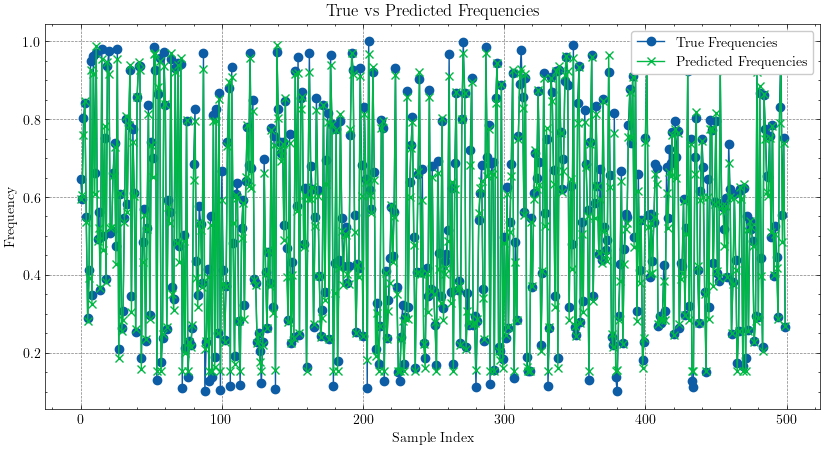

In [12]:
# plot the results
plt.figure(figsize=(10, 5))
plt.plot(y_test.numpy(), label="True Frequencies", marker='o')
plt.plot(y_pred_test.numpy(), label="Predicted Frequencies", marker='x')
plt.title("True vs Predicted Frequencies")
plt.xlabel("Sample Index")
plt.ylabel("Frequency")
plt.legend()
plt.show()

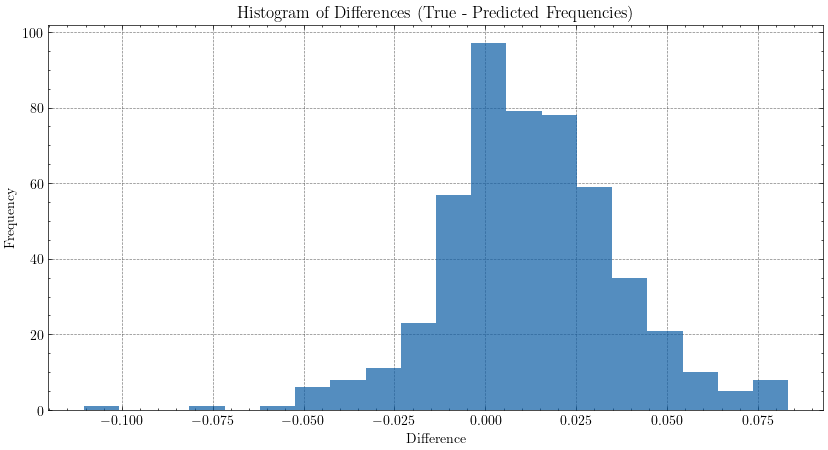

In [13]:
diffs = y_test - y_pred_test
# histogram of the differences
plt.figure(figsize=(10, 5))
plt.hist(diffs.numpy(), bins=20, alpha=0.7)
plt.title("Histogram of Differences (True - Predicted Frequencies)")
plt.xlabel("Difference")
plt.ylabel("Frequency")
plt.show() 

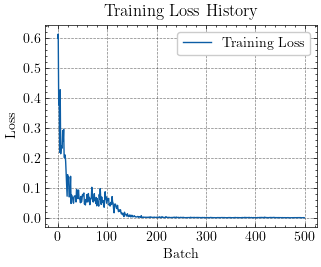

In [14]:
plt.plot(loss_hist, label="Training Loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.title("Training Loss History")
plt.legend()
plt.show()


In [17]:
params_hist_nice = {
    key: np.array([i[key].detach().numpy() for i in params_hist])
    for key in params_hist[0].keys()
}
print(params_hist_nice.keys())

dict_keys(['positions', 'local_pulses_omega_1', 'local_pulses_delta_1', 'global_pulse_omega_1', 'global_pulse_delta_1', 'global_pulse_omega_2', 'global_pulse_delta_2', 'global_pulse_duration', 'local_pulse_duration', 'embed_pulse_duration', 'conv_params', '0.weight', '0.bias', '2.weight', '2.bias', '4.weight', '4.bias'])


In [18]:
positions_hist = np.array([i["positions"].detach().numpy() for i in params_hist])
local_pulses_omega_1_hist = np.array([i["local_pulses_omega_1"].detach().numpy() for i in params_hist])
local_pulses_delta_1_hist = np.array([i["local_pulses_delta_1"].detach().numpy() for i in params_hist])

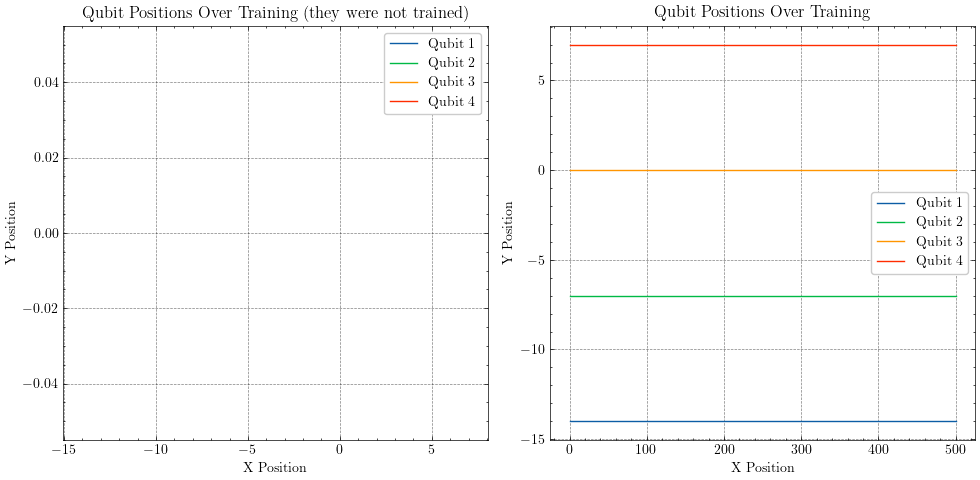

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
plt.sca(axs[0])
for qubit in range(positions_hist.shape[1]):
    plt.plot(positions_hist[:, qubit, 0], positions_hist[:, qubit, 1], label=f"Qubit {qubit+1}")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Qubit Positions Over Training (they were not trained)")
plt.legend()
plt.sca(axs[1])
# only first qubit
plt.plot(positions_hist[:, 0, 0], label="Qubit 1")
plt.plot(positions_hist[:, 1, 0], label="Qubit 2")
plt.plot(positions_hist[:, 2, 0], label="Qubit 3")
plt.plot(positions_hist[:, 3, 0], label="Qubit 4")
# plt.plot(positions_hist[:, 4, 0], label="Qubit 5")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Qubit Positions Over Training")
plt.legend()
plt.tight_layout()  
plt.show()  

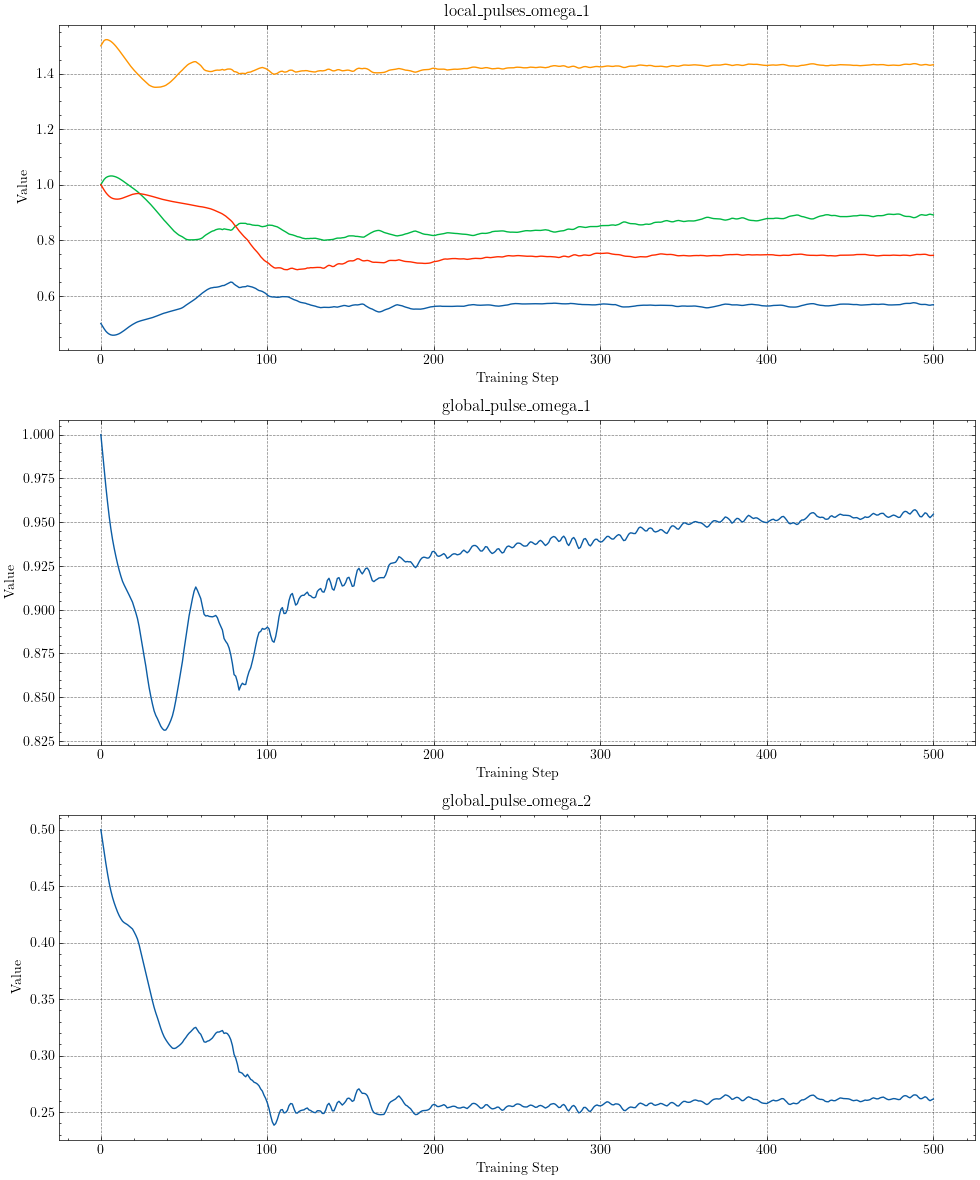

In [20]:
plot_keys = ['local_pulses_omega_1', 'global_pulse_omega_1', 'global_pulse_omega_2']
fig, axs = plt.subplots(len(plot_keys), 1, figsize=(10, 4 * len(plot_keys)))
for i, key in enumerate(plot_keys):
    axs[i].plot(params_hist_nice[key])
    axs[i].set_title(key)
    axs[i].set_xlabel("Training Step")
    axs[i].set_ylabel("Value")
plt.tight_layout()
plt.show()  

In [21]:
import pickle

# number of learned parameters, i.e. with require_grad=True
NAHEA_CNN.train()
# number of parameters
n_params = sum(v.numel() for p, v in NAHEA_CNN.parameters().items() if v.requires_grad)
print(f"Number of trainable parameters: {n_params}")
# save training history
os.makedirs("losses_hist", exist_ok=True)
with open(f"losses_hist/NAHEA_CNN_dist_grad_false_train_hist_2025_07_28_seed_{seed}.pickle", "wb") as f:
    pickle.dump(
        {
            "loss_hist": loss_hist,
            "loss_hist_val": loss_hist_val,
            "params_hist": params_hist,
            "hparams": hparams,
            loss_test.item(): "test_loss",
            "n_learned_parameters": n_params,
        },
        f,
    )

Number of trainable parameters: 143


NameError: name 'seed' is not defined

In [ ]:
# save final parameters
weights_dir = Path("weights")
weights_dir.mkdir(parents=True, exist_ok=True)
with open(weights_dir / f"NAHEA_CNN_sin_dist_grad_false_final_params_2025_07_28_seed_{seed}.pickle", "wb") as f:
    pickle.dump(NAHEA_CNN.parameters(), f)